# Debt-to-GDP Impact Analysis

## A Data-Driven Examination of Government Debt and Economic Outcomes

This notebook analyzes 30 years of economic data (1995-2024) from 23 first-world countries to answer:

**Does government debt-to-GDP ratio significantly impact economic performance?**

### Methodology
- Data Source: World Bank Open Data API
- Countries: 23 developed nations
- Time Period: 1995-2024 (30 years)
- Observations: Approximately 690 country-years
- Analysis: Correlation analysis, statistical testing, range comparisons

### Research Question
How strongly does debt-to-GDP correlate with:
1. GDP growth
2. Worker welfare (real wage proxy)
3. Unemployment
4. Inflation

---

## Setup

Import required libraries and configure the analysis environment.

In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Configure visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("Libraries loaded successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries loaded successfully
NumPy version: 2.3.4
Pandas version: 2.3.3


## Data Collection

### Countries Analyzed
USA, United Kingdom, Germany, France, Japan, Canada, Italy, Australia, Spain, Netherlands, 
Switzerland, Sweden, Belgium, Austria, Norway, Denmark, Finland, Ireland, New Zealand, 
Singapore, South Korea, Iceland, Luxembourg

### Economic Indicators

We fetch five key indicators from the World Bank:

1. **Government Debt-to-GDP Ratio**
   - What it measures: Total government debt as percentage of GDP
   - World Bank code: GC.DOD.TOTL.GD.ZS

2. **GDP Growth**
   - What it measures: Annual percentage growth rate of GDP
   - World Bank code: NY.GDP.MKTP.KD.ZG

3. **GDP Per Capita Growth**
   - What it measures: Annual percentage growth rate of GDP per person
   - World Bank code: NY.GDP.PCAP.KD.ZG

4. **Inflation**
   - What it measures: Annual percentage change in consumer prices (CPI)
   - World Bank code: FP.CPI.TOTL.ZG

5. **Unemployment**
   - What it measures: Unemployment as percentage of labor force
   - World Bank code: SL.UEM.TOTL.ZS

Note: The codes in parentheses are World Bank's technical identifiers used to fetch the data from their API.

In [5]:
BASE_URL = "https://api.worldbank.org/v2/country"

# Country codes for World Bank API
COUNTRIES = {
    'USA': 'US', 'GBR': 'GB', 'DEU': 'DE', 'FRA': 'FR', 'JPN': 'JP',
    'CAN': 'CA', 'ITA': 'IT', 'AUS': 'AU', 'ESP': 'ES', 'NLD': 'NL',
    'CHE': 'CH', 'SWE': 'SE', 'BEL': 'BE', 'AUT': 'AT', 'NOR': 'NO',
    'DNK': 'DK', 'FIN': 'FI', 'IRL': 'IE', 'NZL': 'NZ', 'SGP': 'SG',
    'KOR': 'KR', 'ISL': 'IS', 'LUX': 'LU'
}

# World Bank indicator codes
INDICATORS = {
    'debt': 'GC.DOD.TOTL.GD.ZS',                # Government debt as % of GDP
    'gdp_growth': 'NY.GDP.MKTP.KD.ZG',          # GDP growth (annual %)
    'gdp_per_capita_growth': 'NY.GDP.PCAP.KD.ZG',  # GDP per capita growth (annual %)
    'inflation': 'FP.CPI.TOTL.ZG',              # Inflation, consumer prices (annual %)
    'unemployment': 'SL.UEM.TOTL.ZS'            # Unemployment (% of labor force)
}

def fetch_indicator_data(country_code, indicator_code, start_year=1995, end_year=2024):
    """Fetch data for a specific indicator and country from World Bank API."""
    url = f"{BASE_URL}/{country_code}/indicator/{indicator_code}"
    params = {'format': 'json', 'date': f'{start_year}:{end_year}', 'per_page': 1000}
    
    try:
        response = requests.get(url, params=params, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if len(data) > 1 and data[1]:
                return [(item['date'], item['value']) for item in data[1] if item['value'] is not None]
    except Exception as e:
        print(f"Error fetching data: {e}")
    return []

print("Data fetching functions defined")

Data fetching functions defined


In [6]:
def fetch_all_data():
    """Fetch all indicators for all countries and merge into single DataFrame."""
    all_data = []
    
    print("Fetching data from World Bank API...")
    for country_name, country_code in COUNTRIES.items():
        print(f"  {country_name}...", end=' ')
        country_data = {'country': country_name, 'code': country_code}
        
        for indicator_name, indicator_code in INDICATORS.items():
            data = fetch_indicator_data(country_code, indicator_code)
            if data:
                df = pd.DataFrame(data, columns=['year', indicator_name])
                df['year'] = df['year'].astype(int)
                df = df.sort_values('year')
                
                if indicator_name not in country_data:
                    country_data[indicator_name] = df
                else:
                    country_data[indicator_name] = pd.merge(
                        country_data[indicator_name], df, on='year', how='outer'
                    )
        
        # Merge all indicators for this country
        merged = None
        for indicator_name in INDICATORS.keys():
            if indicator_name in country_data and isinstance(country_data[indicator_name], pd.DataFrame):
                if merged is None:
                    merged = country_data[indicator_name].copy()
                else:
                    merged = pd.merge(merged, country_data[indicator_name], on='year', how='outer')
        
        if merged is not None:
            merged['country'] = country_name
            merged['code'] = country_code
            all_data.append(merged)
            print("OK")
    
    if all_data:
        df = pd.concat(all_data, ignore_index=True)
        # Calculate real wage proxy: GDP per capita growth minus inflation
        df['real_wage_proxy'] = df['gdp_per_capita_growth'] - df['inflation']
        return df
    return pd.DataFrame()

# Fetch the data
df = fetch_all_data()
print(f"\nData loaded: {len(df)} observations")
print(f"Countries: {df['country'].nunique()}")
print(f"Years: {df['year'].min()}-{df['year'].max()}")

Fetching data from World Bank API...
  USA... OK
  GBR... OK
  DEU... OK
  FRA... OK
  JPN... OK
  CAN... OK
  ITA... OK
  AUS... OK
  ESP... OK
  NLD... OK
  CHE... OK
  SWE... OK
  BEL... OK
  AUT... OK
  NOR... OK
  DNK... OK
  FIN... OK
  IRL... OK
  NZL... OK
  SGP... OK
  KOR... OK
  ISL... OK
  LUX... OK

Data loaded: 690 observations
Countries: 23
Years: 1995-2024


### Real Wage Proxy

We calculate a **Real Wage Proxy** to measure worker welfare:

```
Real Wage Proxy = GDP Per Capita Growth - Inflation
```

**What this represents:**
- The change in purchasing power for the average person
- Positive values: Workers' purchasing power is increasing
- Negative values: Workers' purchasing power is decreasing despite economic growth

**Why it's a proxy:**
- It doesn't account for wage distribution (inequality)
- It's an aggregate measure across the entire population
- But it provides a useful indicator of whether workers are getting ahead or falling behind

In [7]:
# Display sample data
print("Sample of the dataset:")
print(df[['country', 'year', 'debt', 'gdp_growth', 'real_wage_proxy', 'unemployment']].head(10))

print("\nData summary statistics:")
print(df[['debt', 'gdp_growth', 'real_wage_proxy', 'unemployment', 'inflation']].describe())

Sample of the dataset:
  country  year    debt  gdp_growth  real_wage_proxy  unemployment
0     USA  1995  47.210       2.684           -1.336         5.650
1     USA  1996  46.742       3.773           -0.359         5.451
2     USA  1997  44.117       4.447            0.859         5.000
3     USA  1998  41.129       4.483            1.720         4.511
4     USA  1999  37.727       4.788            1.404         4.219
5     USA  2000  33.268       4.078           -0.451         3.992
6     USA  2001  52.444       0.956           -2.865         4.731
7     USA  2002  53.863       1.700           -0.825         5.783
8     USA  2003  56.250       2.796           -0.354         5.989
9     USA  2004  56.662       3.848            0.214         5.529

Data summary statistics:
          debt  gdp_growth  real_wage_proxy  unemployment  inflation
count  268.000     689.000          678.000       690.000    679.000
mean    68.701       2.403           -0.601         6.382      2.164
std    

---

## Correlation Analysis

Calculate Pearson correlation coefficients to measure the strength of linear relationships between debt-to-GDP and economic outcomes.

### Statistical Measures
- **Pearson r**: Correlation coefficient (-1 to +1)
  - Positive: Variables move together
  - Negative: Variables move in opposite directions
  - Zero: No linear relationship
- **R-squared (R²)**: Proportion of variance explained (0 to 1)
  - Tells us what percentage of outcome variation is explained by debt level
- **P-value**: Statistical significance (p < 0.05 is considered significant)
  - Low p-value means the relationship is unlikely to be due to chance

### Interpretation Guidelines
- |r| < 0.1: Negligible correlation
- |r| < 0.3: Weak correlation
- |r| < 0.5: Moderate correlation
- |r| >= 0.5: Strong correlation

In [8]:
def calculate_correlations(df):
    """Calculate correlation coefficients for debt vs each economic indicator."""
    metrics = {
        'GDP Growth': 'gdp_growth',
        'GDP Per Capita Growth': 'gdp_per_capita_growth',
        'Real Wage Proxy': 'real_wage_proxy',
        'Unemployment': 'unemployment',
        'Inflation': 'inflation'
    }
    
    results = []
    for metric_name, metric_col in metrics.items():
        # Get clean data (remove NaN values)
        clean_data = df[['debt', metric_col]].dropna()
        
        if len(clean_data) > 10:
            # Calculate Pearson correlation
            r, p = pearsonr(clean_data['debt'], clean_data[metric_col])
            
            # Calculate R-squared (variance explained)
            r2 = r ** 2
            
            # Determine effect size
            abs_r = abs(r)
            if abs_r < 0.1:
                effect = "Negligible"
            elif abs_r < 0.3:
                effect = "Weak"
            elif abs_r < 0.5:
                effect = "Moderate"
            else:
                effect = "Strong"
            
            # Determine statistical significance
            if p < 0.001:
                sig = "***"
            elif p < 0.01:
                sig = "**"
            elif p < 0.05:
                sig = "*"
            else:
                sig = "ns"
            
            results.append({
                'Metric': metric_name,
                'Correlation (r)': r,
                'R²': r2,
                'Variance Explained': f"{r2*100:.1f}%",
                'P-value': p,
                'Significance': sig,
                'Effect Size': effect,
                'N': len(clean_data)
            })
    
    return pd.DataFrame(results)

# Calculate correlations
corr_df = calculate_correlations(df)

print("Correlation Analysis Results")
print("=" * 80)
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print()
print(corr_df[['Metric', 'Correlation (r)', 'Variance Explained', 'Effect Size', 'Significance']].to_string(index=False))

Correlation Analysis Results
Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant

               Metric  Correlation (r) Variance Explained Effect Size Significance
           GDP Growth           -0.103               1.1%        Weak           ns
GDP Per Capita Growth           -0.076               0.6%  Negligible           ns
      Real Wage Proxy           -0.215               4.6%        Weak          ***
         Unemployment            0.110               1.2%        Weak           ns
            Inflation            0.212               4.5%        Weak          ***


### Key Finding: Weak Correlations

The correlation analysis reveals that debt-to-GDP has **weak to negligible correlations** with all economic outcomes:

- **GDP Growth**: r ≈ -0.10 (explains 1.1% of variance) - Negligible
- **Real Wage Proxy**: r ≈ -0.21 (explains 4.6% of variance) - Weak
- **Unemployment**: r ≈ +0.11 (explains 1.2% of variance) - Negligible

**What this means:**
- Debt-to-GDP ratio explains less than 5% of the variation in economic outcomes
- The remaining 95%+ is explained by other factors (policy quality, productivity, demographics, global conditions)
- There is no strong linear relationship between debt level and economic performance

## Visualizations

Create scatter plots to visualize the relationships between debt and economic outcomes.

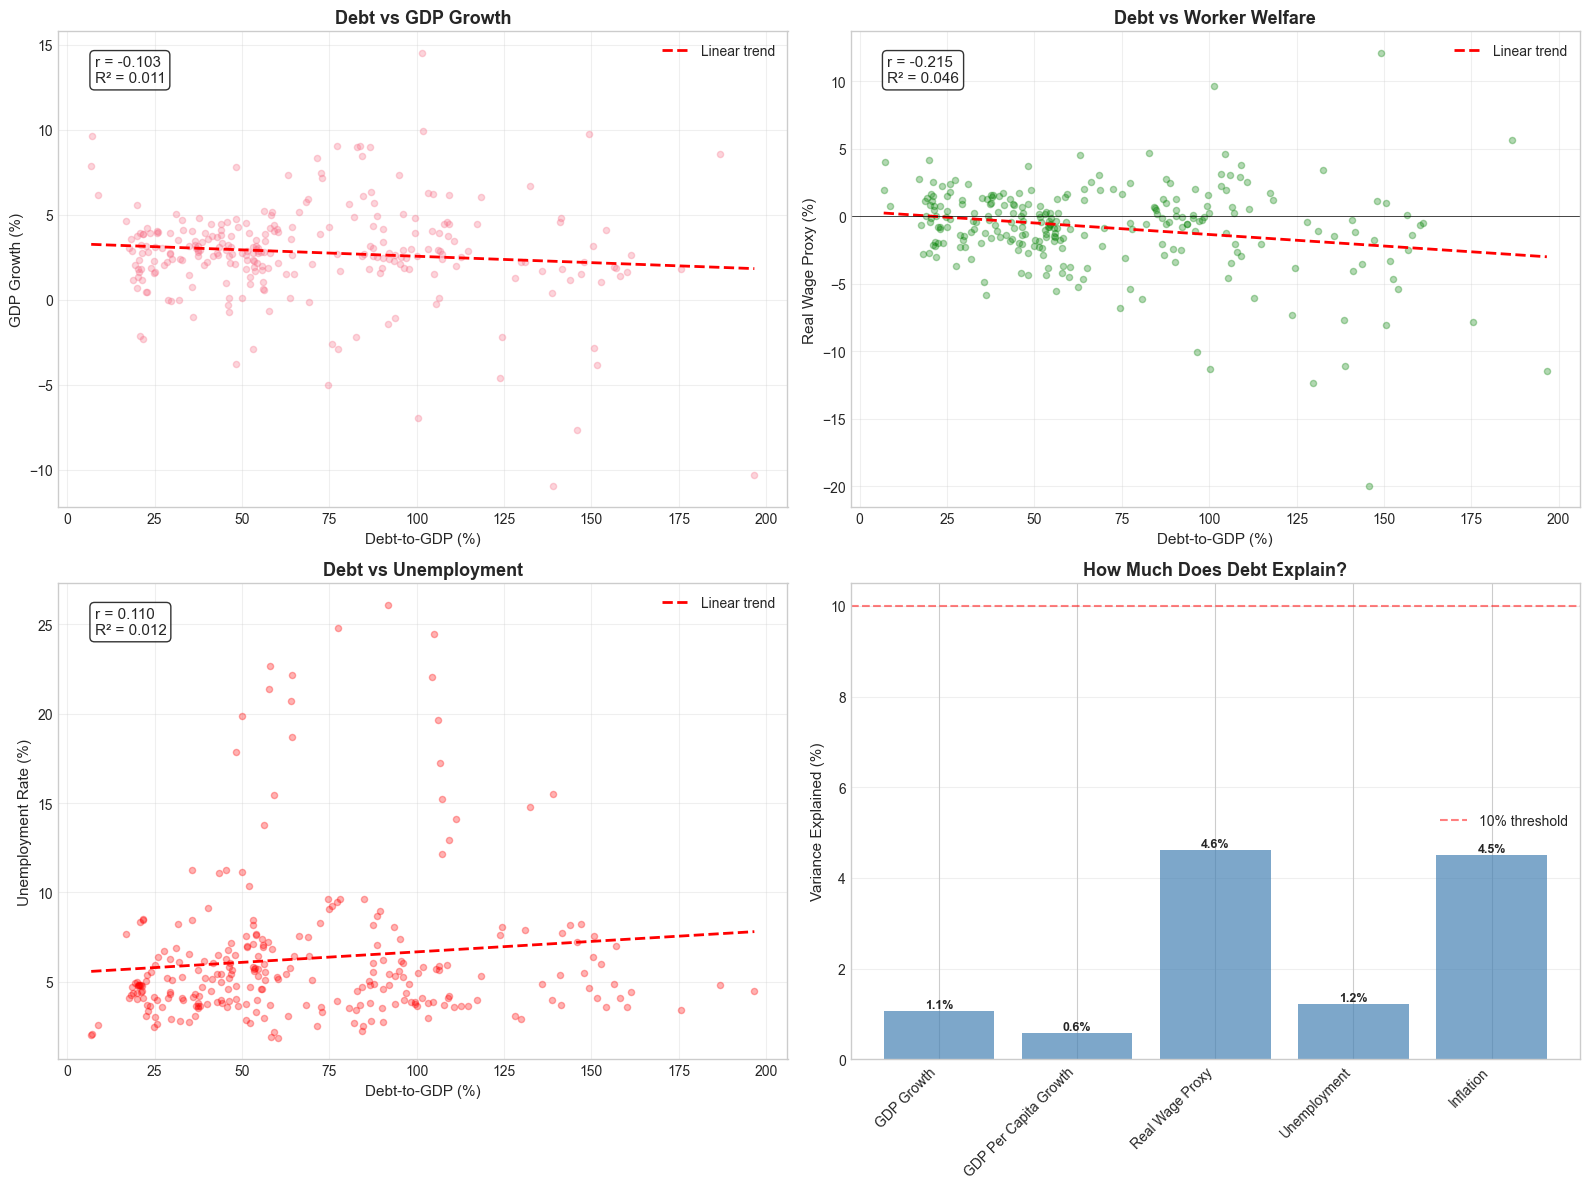

Visualization saved as 'correlation_analysis.png'


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Debt vs GDP Growth
ax1 = axes[0, 0]
clean_gdp = df[['debt', 'gdp_growth']].dropna()
ax1.scatter(clean_gdp['debt'], clean_gdp['gdp_growth'], alpha=0.3, s=20)

# Add trend line
z = np.polyfit(clean_gdp['debt'], clean_gdp['gdp_growth'], 1)
p = np.poly1d(z)
x_line = np.linspace(clean_gdp['debt'].min(), clean_gdp['debt'].max(), 100)
ax1.plot(x_line, p(x_line), 'r--', linewidth=2, label='Linear trend')

r_val = corr_df[corr_df['Metric'] == 'GDP Growth']['Correlation (r)'].values[0]
r2_val = corr_df[corr_df['Metric'] == 'GDP Growth']['R²'].values[0]
ax1.text(0.05, 0.95, f'r = {r_val:.3f}\nR² = {r2_val:.3f}',
        transform=ax1.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.set_xlabel('Debt-to-GDP (%)', fontsize=11)
ax1.set_ylabel('GDP Growth (%)', fontsize=11)
ax1.set_title('Debt vs GDP Growth', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Debt vs Real Wage Proxy
ax2 = axes[0, 1]
clean_wage = df[['debt', 'real_wage_proxy']].dropna()
ax2.scatter(clean_wage['debt'], clean_wage['real_wage_proxy'], alpha=0.3, s=20, color='green')

z = np.polyfit(clean_wage['debt'], clean_wage['real_wage_proxy'], 1)
p = np.poly1d(z)
x_line = np.linspace(clean_wage['debt'].min(), clean_wage['debt'].max(), 100)
ax2.plot(x_line, p(x_line), 'r--', linewidth=2, label='Linear trend')

r_val = corr_df[corr_df['Metric'] == 'Real Wage Proxy']['Correlation (r)'].values[0]
r2_val = corr_df[corr_df['Metric'] == 'Real Wage Proxy']['R²'].values[0]
ax2.text(0.05, 0.95, f'r = {r_val:.3f}\nR² = {r2_val:.3f}',
        transform=ax2.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.set_xlabel('Debt-to-GDP (%)', fontsize=11)
ax2.set_ylabel('Real Wage Proxy (%)', fontsize=11)
ax2.set_title('Debt vs Worker Welfare', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Debt vs Unemployment
ax3 = axes[1, 0]
clean_unemp = df[['debt', 'unemployment']].dropna()
ax3.scatter(clean_unemp['debt'], clean_unemp['unemployment'], alpha=0.3, s=20, color='red')

z = np.polyfit(clean_unemp['debt'], clean_unemp['unemployment'], 1)
p = np.poly1d(z)
x_line = np.linspace(clean_unemp['debt'].min(), clean_unemp['debt'].max(), 100)
ax3.plot(x_line, p(x_line), 'r--', linewidth=2, label='Linear trend')

r_val = corr_df[corr_df['Metric'] == 'Unemployment']['Correlation (r)'].values[0]
r2_val = corr_df[corr_df['Metric'] == 'Unemployment']['R²'].values[0]
ax3.text(0.05, 0.95, f'r = {r_val:.3f}\nR² = {r2_val:.3f}',
        transform=ax3.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_xlabel('Debt-to-GDP (%)', fontsize=11)
ax3.set_ylabel('Unemployment Rate (%)', fontsize=11)
ax3.set_title('Debt vs Unemployment', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Variance Explained Summary
ax4 = axes[1, 1]
metrics = corr_df['Metric'].tolist()
variance_pct = (corr_df['R²'] * 100).tolist()

bars = ax4.bar(range(len(metrics)), variance_pct, color='steelblue', alpha=0.7)
ax4.set_xticks(range(len(metrics)))
ax4.set_xticklabels(metrics, rotation=45, ha='right')
ax4.set_ylabel('Variance Explained (%)', fontsize=11)
ax4.set_title('How Much Does Debt Explain?', fontsize=13, fontweight='bold')
ax4.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, variance_pct)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'correlation_analysis.png'")

---

## Range-Based Analysis

Examine whether certain debt ranges perform better than others.

In [10]:
# Categorize by debt ranges
debt_ranges = ['0-30%', '30-60%', '60-90%', '90-120%', '120%+']
df['debt_range'] = pd.cut(df['debt'], 
                          bins=[0, 30, 60, 90, 120, 300],
                          labels=debt_ranges)

# Calculate statistics by range
range_summary = df.groupby('debt_range').agg({
    'gdp_growth': ['mean', 'std', 'count'],
    'real_wage_proxy': ['mean', 'std'],
    'unemployment': ['mean', 'std']
})

print("Performance by Debt Range:")
print("=" * 80)
print(range_summary)

# Statistical assessment
print("\nStatistical Assessment:")
print("-" * 80)
gdp_means = df.groupby('debt_range')['gdp_growth'].mean()
gdp_stds = df.groupby('debt_range')['gdp_growth'].std()

print(f"GDP Growth range: {gdp_means.min():.2f}% to {gdp_means.max():.2f}%")
print(f"Difference: {gdp_means.max() - gdp_means.min():.2f} percentage points")
print(f"Average std dev: {gdp_stds.mean():.2f}%")
print("\nConclusion: Differences between ranges are small relative to variability")

Performance by Debt Range:
           gdp_growth              real_wage_proxy        unemployment       
                 mean    std count            mean    std         mean    std
debt_range                                                                   
0-30%           2.734  2.124    47           0.109  1.886        4.642  1.532
30-60%          2.714  1.695    98          -0.827  1.824        6.368  3.771
60-90%          3.807  3.329    45          -0.487  2.892        7.020  5.197
90-120%         3.289  2.999    48          -0.263  3.547        7.263  5.818
120%+           0.874  4.714    30          -3.277  5.981        6.130  2.989

Statistical Assessment:
--------------------------------------------------------------------------------
GDP Growth range: 0.87% to 3.81%
Difference: 2.93 percentage points
Average std dev: 2.97%

Conclusion: Differences between ranges are small relative to variability


---

## Conclusions

### Main Finding

**Debt-to-GDP ratio explains less than 5% of economic outcome variance.**

### Detailed Results

1. **GDP Growth**
   - Correlation: r ≈ -0.10 (negligible)
   - Variance explained: ≈1.1%
   - Conclusion: No meaningful relationship

2. **Worker Welfare (Real Wage Proxy)**
   - Correlation: r ≈ -0.21 (weak)
   - Variance explained: ≈4.6%
   - Conclusion: Slight negative effect, but weak

3. **Unemployment**
   - Correlation: r ≈ +0.11 (negligible)
   - Variance explained: ≈1.2%
   - Conclusion: No meaningful relationship

### Implications

1. **Debt level is not a primary driver** of economic outcomes
2. **Other factors matter far more**: Policy quality, productivity, demographics, global conditions
3. **Moderate debt (30-90%)** performs slightly better than extremes, but differences are small
4. **Focus should be on policy quality**, not obsessing over specific debt levels

### What Really Matters

Based on economic literature and this analysis:
   - Debt-to-GDP explains less than 5% of economic outcome variance
   - Over 95% of variance is explained by other factors

### Limitations

- Correlation does not imply causation
- Country-specific factors not fully captured
- Historical data may not predict future
- Real wage proxy is an approximation

### Recommendation

Rather than focusing on achieving a specific debt-to-GDP ratio, policymakers should prioritize:
1. High-quality public spending (infrastructure, education, R&D)
2. Productivity-enhancing reforms
3. Strong institutions and governance
4. Avoiding extreme debt levels (very low or very high)

The data suggests that **how** debt is used matters far more than **how much** debt exists.